In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # https://stackoverflow.com/questions/63746182/correct-way-of-normalizing-and-scaling-the-mnist-dataset
])


full_train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


train_size = 50000
val_size = 10000

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [3]:
class MNISTSelfDataset(Dataset):
    def __init__(self, mnist):
        self.mnist = mnist

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        image, _ = self.mnist[idx]
        return torch.flatten(image), torch.flatten(image)
    
self_train_dataset = MNISTSelfDataset(train_dataset)
self_val_dataset = MNISTSelfDataset(val_dataset)
self_test_dataset = MNISTSelfDataset(test_dataset)

self_train_loader = DataLoader(dataset=self_train_dataset, batch_size=64, shuffle=True)
self_val_loader = DataLoader(dataset=self_val_dataset, batch_size=64, shuffle=False)
self_test_loader = DataLoader(dataset=self_test_dataset, batch_size=64, shuffle=False)

In [4]:
class MNISTNoisyDataset(Dataset):
    def __init__(self, mnist):
        self.mnist = mnist

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        image, _ = self.mnist[idx]
        flattened_img = torch.flatten(image)
        return flattened_img + torch.rand_like(flattened_img), flattened_img
    
noisy_train_dataset = MNISTNoisyDataset(train_dataset)
noisy_val_dataset = MNISTNoisyDataset(val_dataset)
noisy_test_dataset = MNISTNoisyDataset(test_dataset)

noisy_train_loader = DataLoader(dataset=noisy_train_dataset, batch_size=64, shuffle=True)
noisy_val_loader = DataLoader(dataset=noisy_val_dataset, batch_size=64, shuffle=False)
noisy_test_loader = DataLoader(dataset=noisy_test_dataset, batch_size=64, shuffle=False)

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, intermediary_layer_size, latent_space_size) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size, intermediary_layer_size)
        self.fc2 = nn.Linear(intermediary_layer_size, latent_space_size)
        

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        return x

class Decoder(nn.Module):
    def __init__(self, latent_space_size, intermediary_layer_size, output_size) -> None:
        super().__init__()
        self.fc1 = nn.Linear(latent_space_size, intermediary_layer_size)
        self.fc2 = nn.Linear(intermediary_layer_size, output_size)
        

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, input_size, output_size, intermediary_layer_size, latent_space_size) -> None:
        super().__init__()
        self.encoder = Encoder(input_size, intermediary_layer_size, latent_space_size)
        self.decoder = Decoder(latent_space_size, intermediary_layer_size, output_size)
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
class LitModel(pl.LightningModule):
    def __init__(self, autoencoder, img_pixel_count, img_size):
        super().__init__()
        self.autoencoder = autoencoder
        
    def forward(self, x):
        x = self.autoencoder(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [7]:
IMG_LENGTH = 28
PIXEL_COUNT = IMG_LENGTH * IMG_LENGTH
INTERMEDIATE_LAYER_SIZE = 360
LATENT_SPACE_SIZE = 20
IMG_SHAPE = (1, IMG_LENGTH, IMG_LENGTH)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=10, verbose=False, mode="max")


In [8]:
def plot_random_samples(test_dataset, autoencoder):
    import random
    random_numbers = [random.randint(0, len(test_dataset) - 1) for _ in range(10)]

    for idx in random_numbers:
        print("Original image: ")
        img = torch.reshape(test_dataset[idx][0], (28, 28))
        plt.imshow(img, cmap='gray')
        plt.show()
        with torch.no_grad():
            print("Autoencoded image: ")
            autoencoded_img = torch.reshape(autoencoder(img.flatten()), (28, 28))
            plt.imshow(autoencoded_img, cmap='gray')
            plt.show()

## Train and display self-reconstructing autoencoder

In [9]:
trainer = pl.Trainer(
    max_epochs=5,
    accelerator='auto',
    devices='auto'
)

autoencoder = Autoencoder(PIXEL_COUNT, PIXEL_COUNT, INTERMEDIATE_LAYER_SIZE, LATENT_SPACE_SIZE)
model = LitModel(autoencoder, PIXEL_COUNT, IMG_SHAPE)

trainer.fit(model, self_train_loader, self_val_loader)
trainer.test(model, self_test_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 580 K  | train
----------------------------------------------------
580 K     Trainable params
0         Non-trainable params
580 K     Total params
2.322     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\yihen\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\yihen\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
C:\Users\yihen\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.38792669773101807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.38792669773101807}]

Original image: 


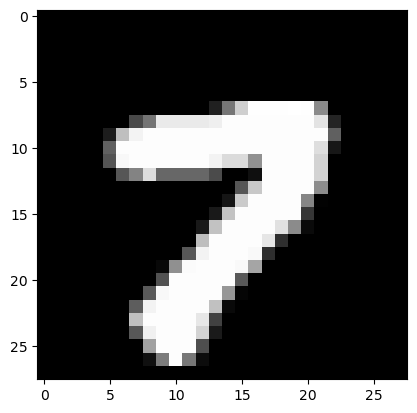

Autoencoded image: 


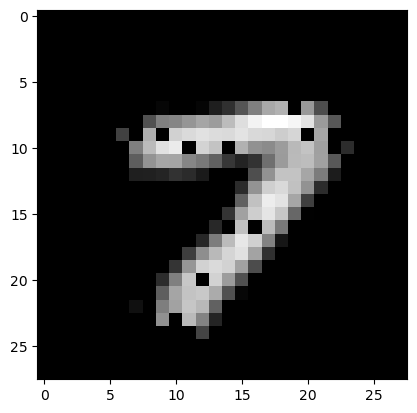

Original image: 


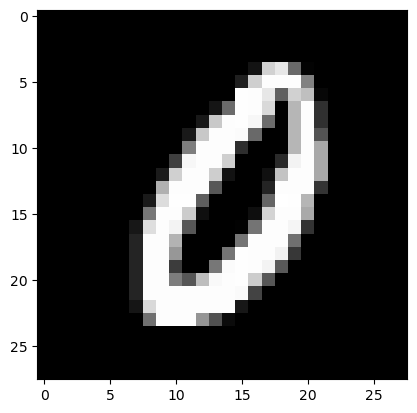

Autoencoded image: 


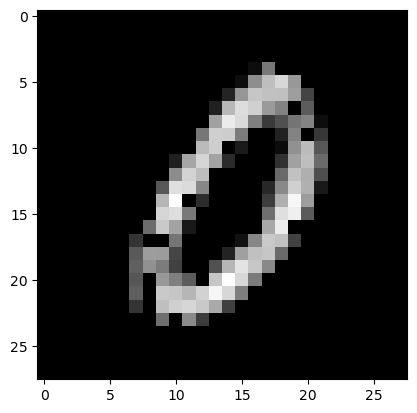

Original image: 


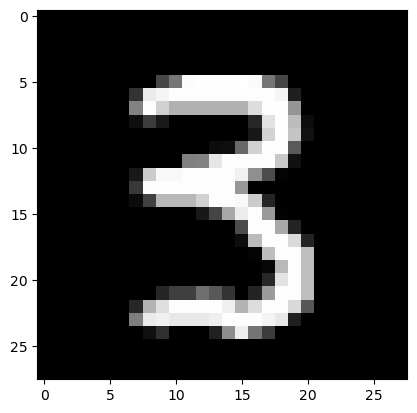

Autoencoded image: 


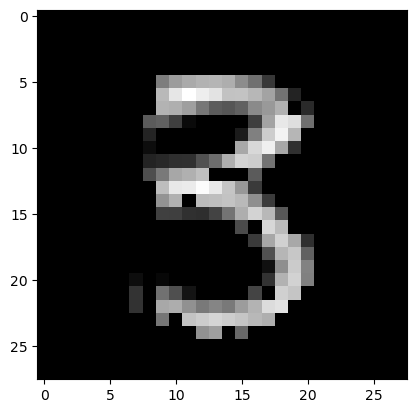

Original image: 


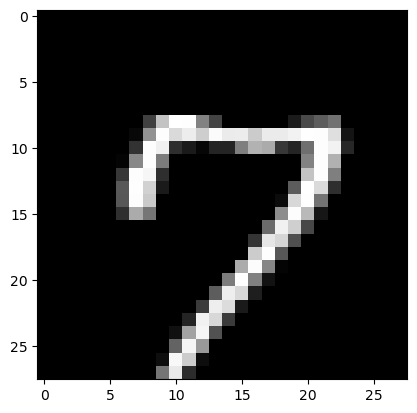

Autoencoded image: 


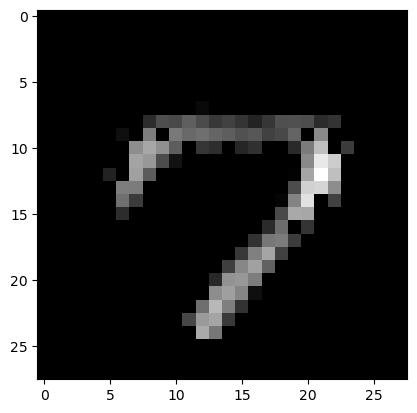

Original image: 


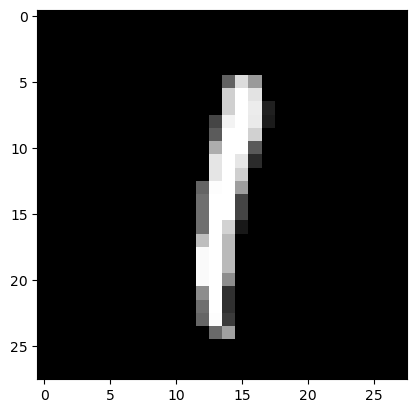

Autoencoded image: 


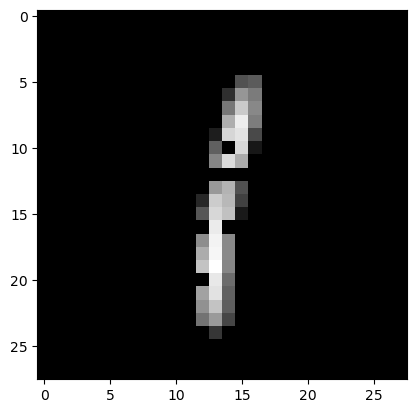

Original image: 


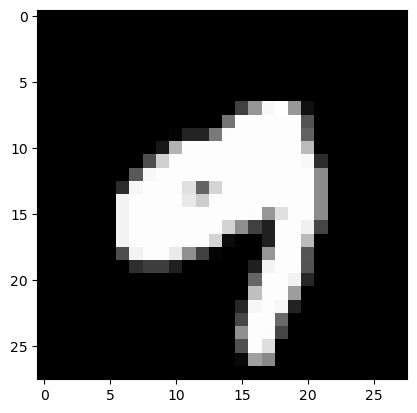

Autoencoded image: 


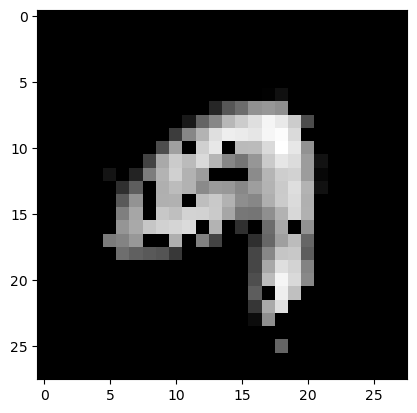

Original image: 


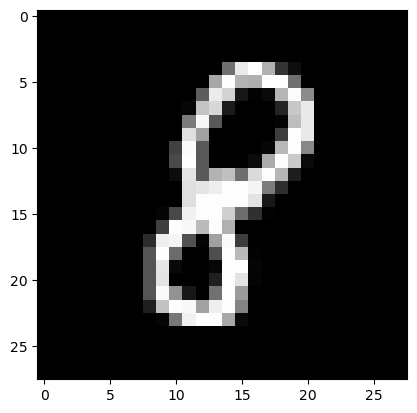

Autoencoded image: 


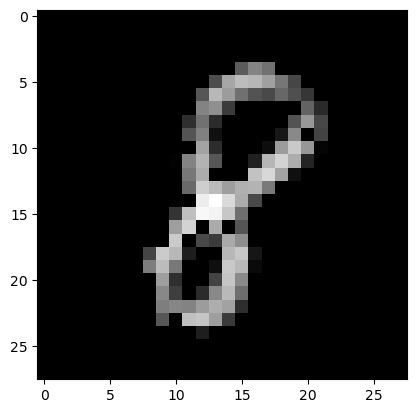

Original image: 


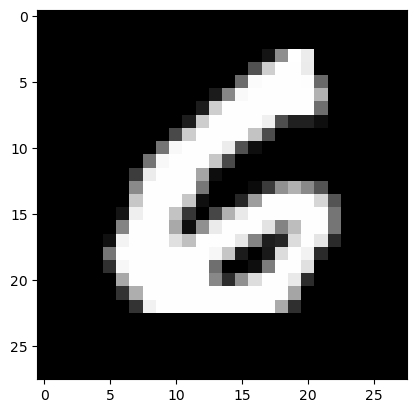

Autoencoded image: 


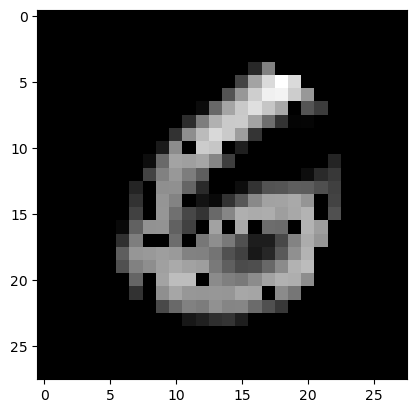

Original image: 


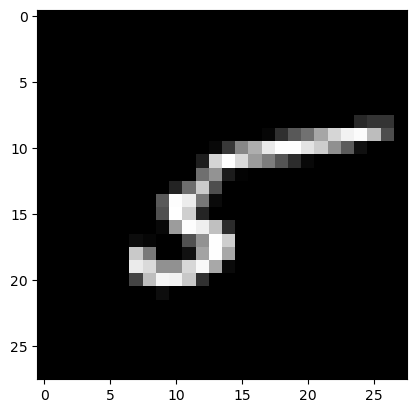

Autoencoded image: 


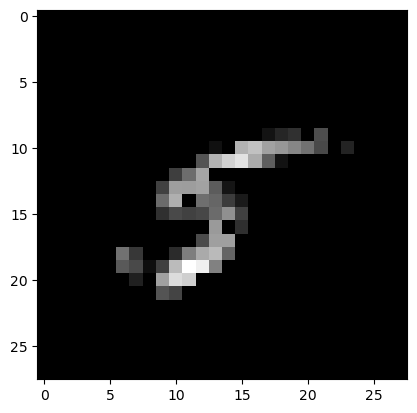

Original image: 


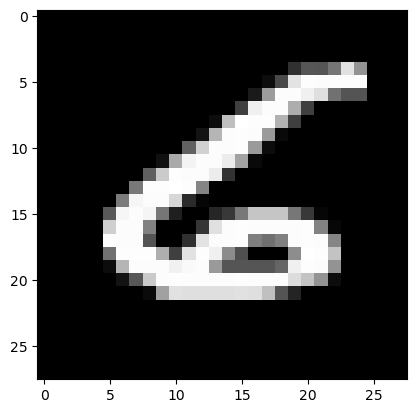

Autoencoded image: 


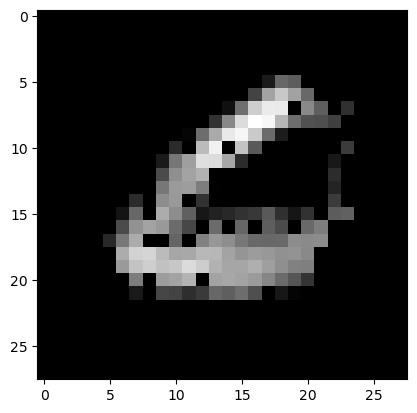

In [10]:
plot_random_samples(self_test_dataset, autoencoder)

## Train and display denoising autoencoder

In [11]:
trainer = pl.Trainer(
    max_epochs=5,
    accelerator='auto',
    devices='auto'
)

autoencoder = Autoencoder(PIXEL_COUNT, PIXEL_COUNT, INTERMEDIATE_LAYER_SIZE, LATENT_SPACE_SIZE)
model = LitModel(autoencoder, PIXEL_COUNT, IMG_SHAPE)

trainer.fit(model, noisy_train_loader, noisy_val_loader)
trainer.test(model, noisy_test_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 580 K  | train
----------------------------------------------------
580 K     Trainable params
0         Non-trainable params
580 K     Total params
2.322     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3809455931186676
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3809455931186676}]

Original image: 


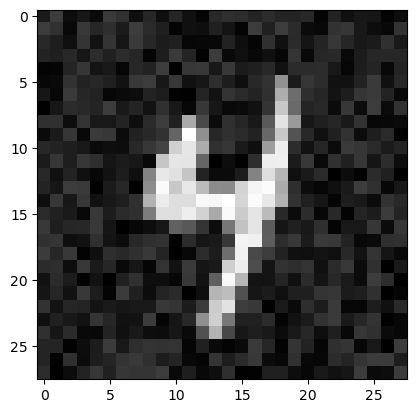

Autoencoded image: 


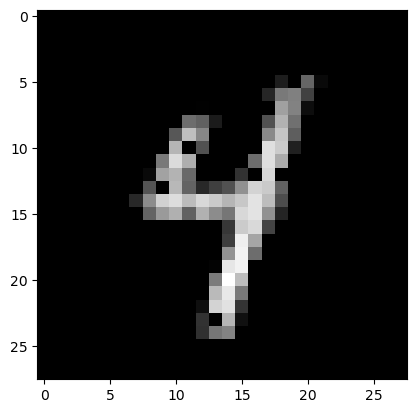

Original image: 


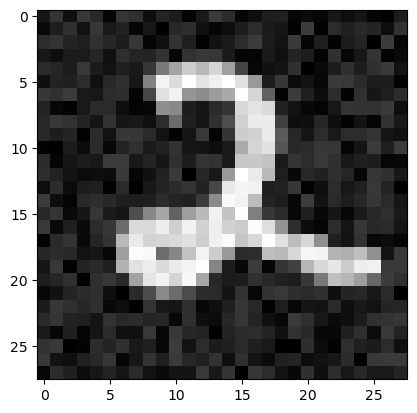

Autoencoded image: 


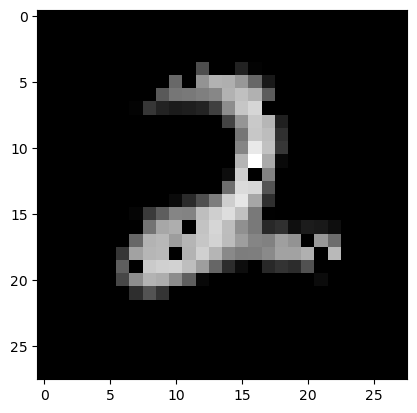

Original image: 


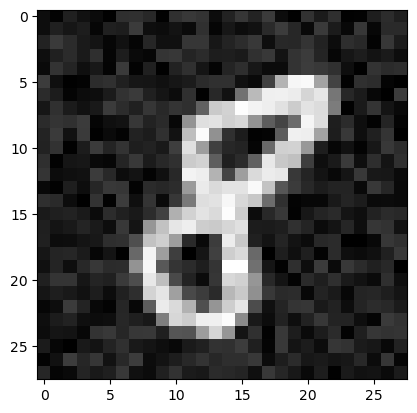

Autoencoded image: 


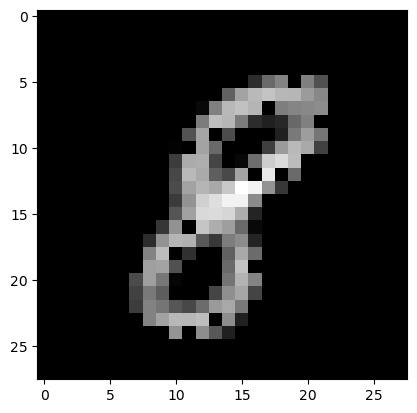

Original image: 


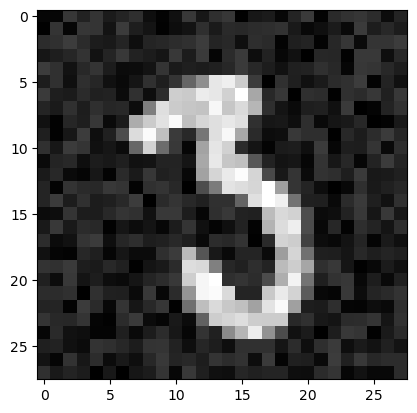

Autoencoded image: 


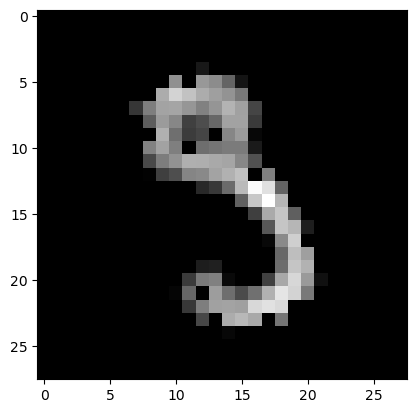

Original image: 


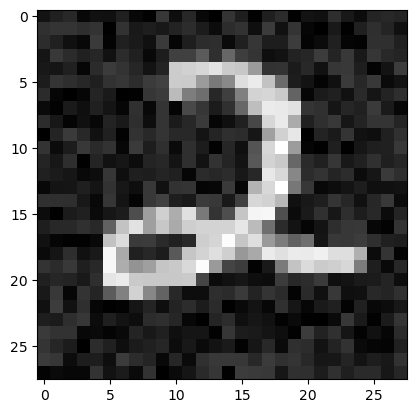

Autoencoded image: 


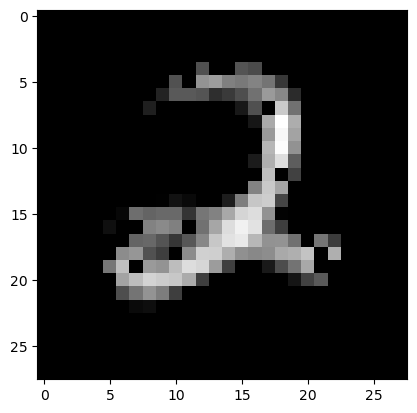

Original image: 


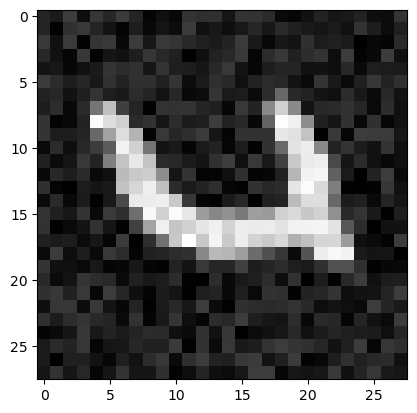

Autoencoded image: 


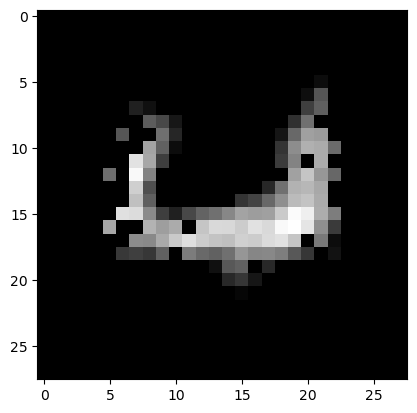

Original image: 


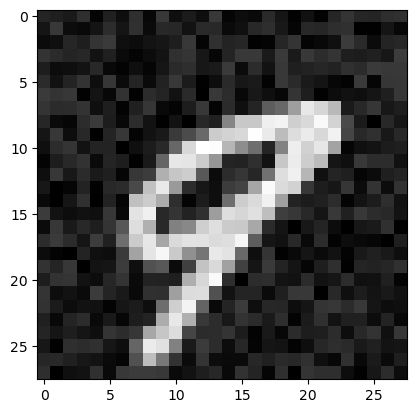

Autoencoded image: 


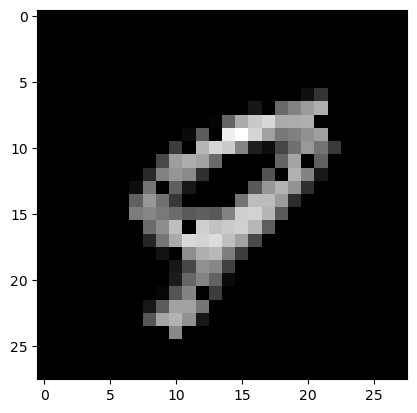

Original image: 


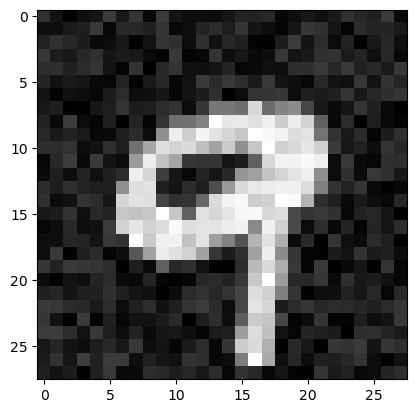

Autoencoded image: 


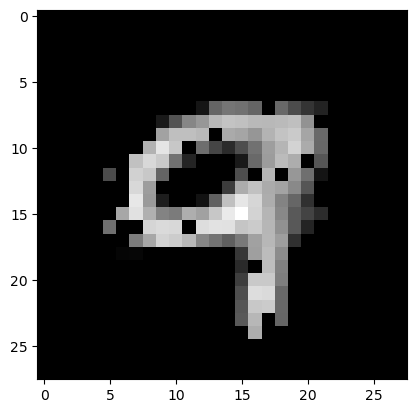

Original image: 


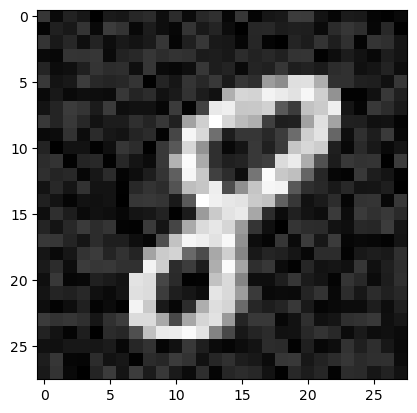

Autoencoded image: 


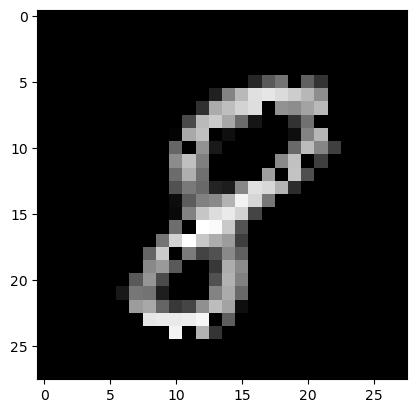

Original image: 


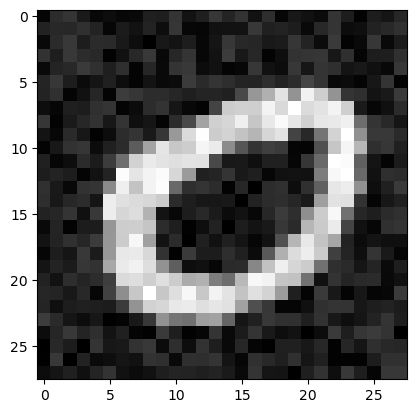

Autoencoded image: 


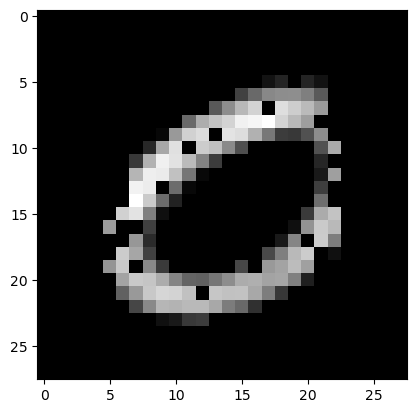

In [12]:
plot_random_samples(noisy_test_dataset, autoencoder)